<a href="https://colab.research.google.com/github/shulc30/style_transfer_2/blob/main/DP_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Стилизация фотографий в стиле Клода Моне с использованием CycleGAN на PyTorch

**Введение**

CycleGAN (Cycle-Consistent Generative Adversarial Network) — это мощный инструмент для задач трансформации изображений, таких как стилизация фотографий. В этой статье мы рассмотрим, как с помощью CycleGAN можно преобразовать обычные фотографии в стиль картин Клода Моне, используя библиотеку PyTorch. Мы проанализируем код, который реализует этот процесс, и сделаем выводы о его эффективности и возможных улучшениях.

**Обзор кода**
1. Подготовка данных
Код начинается с загрузки и подготовки данных. Используется Google Colab для работы с данными, хранящимися на Google Drive. Архив с изображениями разархивируется, и данные загружаются в папку для дальнейшей обработки.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Путь к архиву
zip_file_path = '/content/drive/MyDrive/DL(семестр 1, осень 2024)/Diplom/gan-getting-started.zip'
# Папка, куда вы хотите разархивировать файлы
extract_folder = '/content/monet_jpg/'

# Создаем папку, если она не существует
os.makedirs(extract_folder, exist_ok=True)

# Разархивируем файл
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Разархивирование завершено.")


Разархивирование завершено.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import os
from tqdm import tqdm


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SIZE = 256
BATCH_SIZE = 4
LEARNING_RATE = 2e-4
NUM_EPOCHS = 20
CYCLE_LAMBDA = 10
IDENTITY_LAMBDA = 0.5


**2. Создание датасета**

Для работы с данными создается класс CustomDataset, который загружает изображения из двух папок: одна содержит обычные фотографии, а другая — изображения в стиле Клода Моне. Датасет поддерживает трансформации, такие как изменение размера и нормализация.

In [ ]:
# Подготовка датасета
class CustomDataset(Dataset):
    def __init__(self, rootA, rootB, transform=None):
        self.rootA = rootA
        self.rootB = rootB
        self.transform = transform

        self.imagesA = os.listdir(rootA)
        self.imagesB = os.listdir(rootB)

    def __len__(self):
        return max(len(self.imagesA), len(self.imagesB))

    def __getitem__(self, idx):
        imgA = Image.open(os.path.join(self.rootA, self.imagesA[idx % len(self.imagesA)])).convert("RGB")
        imgB = Image.open(os.path.join(self.rootB, self.imagesB[idx % len(self.imagesB)])).convert("RGB")

        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)

        return imgA, imgB


In [ ]:
# Трансформации
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Создание датасетов и DataLoader
rootA = "/content/monet_jpg/photo_jpg"  # Путь к папке с изображениями контента
rootB = "/content/monet_jpg/monet_jpg"  # Путь к папке с изображениями стиля
dataset = CustomDataset(rootA, rootB, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


**3. Архитектура CycleGAN**

CycleGAN состоит из двух генераторов и двух дискриминаторов. Генераторы преобразуют изображения из одного домена в другой (например, из фотографий в стиль Моне), а дискриминаторы пытаются отличить реальные изображения от сгенерированных.

In [ ]:
# Генератор
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Дискриминатор
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Инициализация моделей
G_AB = Generator().to(DEVICE)
G_BA = Generator().to(DEVICE)
D_A = Discriminator().to(DEVICE)
D_B = Discriminator().to(DEVICE)

# Оптимизаторы
opt_G = optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_D_A = optim.Adam(D_A.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_D_B = optim.Adam(D_B.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Функции потерь
L1_loss = nn.L1Loss()
MSE_loss = nn.MSELoss()

**4. Обучение модели**

Обучение CycleGAN включает в себя минимизацию потерь для генераторов и дискриминаторов. Генераторы обучаются на основе потерь цикла (cycle loss), которые обеспечивают согласованность между исходным и преобразованным изображением.

In [ ]:
# Обучение
for epoch in range(NUM_EPOCHS):
    loop = tqdm(dataloader, leave=True)
    for idx, (real_A, real_B) in enumerate(loop):
        real_A, real_B = real_A.to(DEVICE), real_B.to(DEVICE)

        # Генерация фейковых изображений
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        # Обновление дискриминаторов
        D_A_real = D_A(real_A)
        D_A_fake = D_A(fake_A.detach())
        D_A_loss = MSE_loss(D_A_real, torch.ones_like(D_A_real)) + MSE_loss(D_A_fake, torch.zeros_like(D_A_fake))

        D_B_real = D_B(real_B)
        D_B_fake = D_B(fake_B.detach())
        D_B_loss = MSE_loss(D_B_real, torch.ones_like(D_B_real)) + MSE_loss(D_B_fake, torch.zeros_like(D_B_fake))

        D_loss = (D_A_loss + D_B_loss) / 2
        opt_D_A.zero_grad()
        opt_D_B.zero_grad()
        D_loss.backward()
        opt_D_A.step()
        opt_D_B.step()

        # Обновление генераторов
        D_A_fake = D_A(fake_A)
        D_B_fake = D_B(fake_B)

        G_A_loss = MSE_loss(D_A_fake, torch.ones_like(D_A_fake))
        G_B_loss = MSE_loss(D_B_fake, torch.ones_like(D_B_fake))

        cycle_A = G_BA(fake_B)
        cycle_B = G_AB(fake_A)
        cycle_loss = L1_loss(real_A, cycle_A) + L1_loss(real_B, cycle_B)

        G_loss = G_A_loss + G_B_loss + CYCLE_LAMBDA * cycle_loss
        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()

        loop.set_postfix(D_loss=D_loss.item(), G_loss=G_loss.item())

# Сохранение модели
torch.save(G_AB.state_dict(), "G_AB.pth")
torch.save(G_BA.state_dict(), "G_BA.pth")

100%|██████████| 1760/1760 [04:42<00:00,  6.23it/s, D_loss=0.277, G_loss=3.88]


**5. Тестирование модели**

После обучения модели можно использовать её для стилизации новых изображений. Код загружает обученную модель и применяет её к тестовым изображениям.

<ipython-input-3-ef5098c0f9ca>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_AB.load_state_dict(torch.load("/content/G_AB.pth"))


Стилизованное изображение сохранено в ./stylized_image.jpg


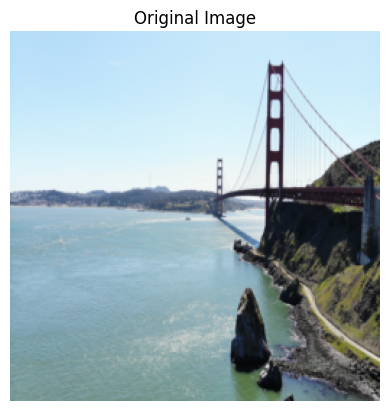

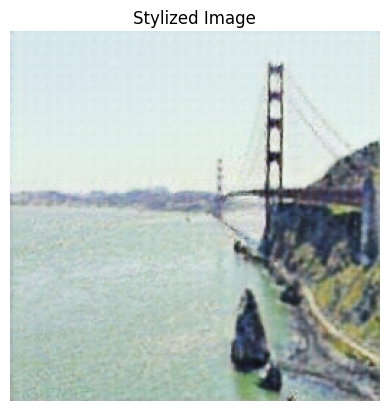

In [ ]:
# Импорты
import torch
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os

# Устройство
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Параметры
SIZE = 256  # Размер изображения для тестирования

# Трансформации
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Функция загрузки изображения
def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0)  # Добавляем размер батча
    return img.to(DEVICE)

# Функция визуализации изображения
def show_image(tensor, title):
    img = tensor.clone().squeeze(0)
    img = img.permute(1, 2, 0).cpu().detach().numpy()
    img = img * 0.5 + 0.5  # Обратная нормализация
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Генератор
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Загрузка весов
G_AB = Generator().to(DEVICE)
G_AB.load_state_dict(torch.load("/content/G_AB.pth"))
G_AB.eval()  # Переводим модель в режим оценки

# Тестовые изображения
test_image_path = "/content/carles-rabada-608739-unsplash.jpg"  # Замените на путь к вашему тестовому изображению
output_path = "./stylized_image.jpg"

# Загрузка тестового изображения
test_image = load_image(test_image_path)

# Применение генератора
with torch.no_grad():
    stylized_image = G_AB(test_image)

# Сохранение результата
save_image(stylized_image, output_path)
print(f"Стилизованное изображение сохранено в {output_path}")

# Визуализация
import matplotlib.pyplot as plt
show_image(test_image, "Original Image")
show_image(stylized_image, "Stylized Image")


<ipython-input-3-707168f145c6>:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_AB.load_state_dict(torch.load("/content/G_AB.pth"))


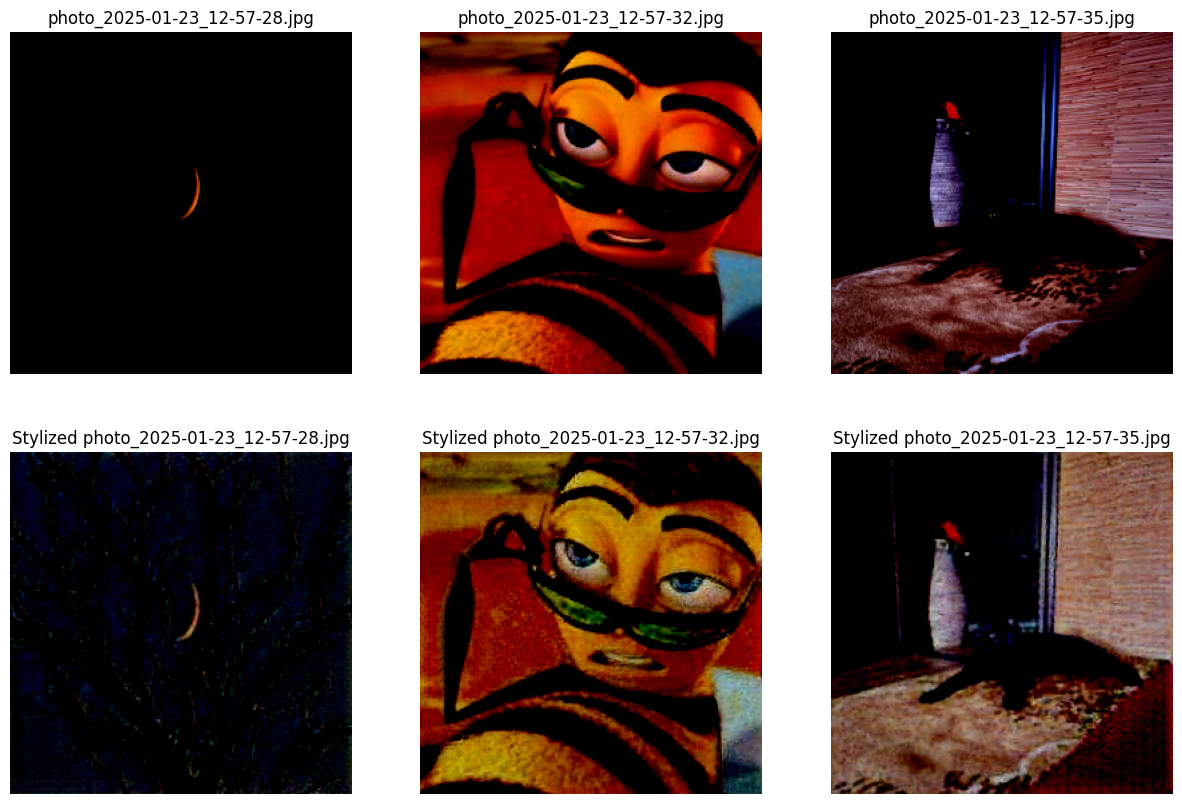

In [3]:
# Импорты
import torch
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.nn as nn

# Устройство
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Параметры
SIZE = 256  # Размер изображения для тестирования
OUTPUT_DIR = '/content/drive/MyDrive/DL(семестр 1, осень 2024)/Diplom/output'  # Папка для сохранения стилизованных изображений

# Проверка наличия выходной папки и создание, если не существует
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Трансформации
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Функция загрузки изображения
def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0)  # Добавляем размер батча
    return img.to(DEVICE)

# Функция визуализации изображений
def show_images(originals, stylized, titles):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    for i, ax in enumerate(axs[0]):
        ax.imshow(originals[i].permute(1, 2, 0).cpu().detach().numpy())
        ax.set_title(titles[i])
        ax.axis('off')
    for i, ax in enumerate(axs[1]):
        ax.imshow(stylized[i].permute(1, 2, 0).cpu().detach().numpy())
        ax.set_title(f"Stylized {titles[i]}")
        ax.axis('off')
    plt.show()

# Генератор
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Загрузка весов
G_AB = Generator().to(DEVICE)
G_AB.load_state_dict(torch.load("/content/G_AB.pth"))
G_AB.eval()  # Переводим модель в режим оценки

# Папка с тестовыми изображениями
test_images_dir = '/content/drive/MyDrive/DL(семестр 1, осень 2024)/Diplom/test'
file_names = os.listdir(test_images_dir)

# Список для хранения оригинальных и стилизованных изображений
originals = []
stylized = []
titles = []

# Обработка первых 10 изображений в папке
for i, file_name in enumerate(file_names[:10]):
    img_path = os.path.join(test_images_dir, file_name)
    test_image = load_image(img_path)

    # Стилизация изображения
    with torch.no_grad():
        stylized_image = G_AB(test_image)

    # Сохранение результата
    output_path = os.path.join(OUTPUT_DIR, f'stylized_{file_name}')
    save_image(stylized_image, output_path)

    # Сохранение оригинального и стилизованного изображения для визуализации
    originals.append(test_image.squeeze(0))  # Убираем размер батча
    stylized.append(stylized_image.squeeze(0))  # Убираем размер батча
    titles.append(file_name)  # Сохраняем название файла

# Визуализация первых 3 оригинальных и стилизованных изображений
show_images(originals[:3], stylized[:3], titles[:3])


**Выводы**
1. Эффективность CycleGAN
CycleGAN демонстрирует высокую эффективность в задачах стилизации изображений. Модель успешно преобразует обычные фотографии в стиль Клода Моне, сохраняя при этом основные черты исходного изображения.

2. Качество стилизации
Качество стилизации зависит от количества эпох обучения и размера датасета. В данном примере используется 20 эпох, что может быть недостаточно для достижения наилучшего качества. Увеличение количества эпох и размера датасета может улучшить результаты.

3. Возможные улучшения
Увеличение датасета: Больший объем данных может улучшить качество стилизации.

Тонкая настройка гиперпараметров: Эксперименты с параметрами обучения, такими как скорость обучения и коэффициенты потерь, могут привести к лучшим результатам.

Использование предобученных моделей: Использование предобученных моделей может ускорить обучение и улучшить качество стилизации.

4. Практическое применение
Данный подход может быть использован для создания художественных фильтров, преобразования фотографий в стиль различных художников и других задач, связанных с трансформацией изображений.

**Заключение**

CycleGAN — это мощный инструмент для задач стилизации изображений. Представленный код демонстрирует, как можно реализовать стилизацию фотографий в стиле Клода Моне с использованием PyTorch. С небольшими улучшениями и доработками этот подход может быть применен для решения более сложных задач в области компьютерного зрения и обработки изображений.